In [1]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from data_loader import load_data
from utils import plot_2d_visualization

np.random.seed(0)

# MNIST

## PCA Analysis

Q1: How many eigenvalues contain 90%, 75%, 50% 25%, 10% of the data?
Q2: For each pca-reduced set, what is the KL divergence of p_joint and p_joint_pca?
Q3: For each pca-reduced set, what is the KL divergence of q_joint and q_joint pca?
Q4: For each pca-reduced set, what is the l2-norm between the true representation and the pca representation?
Q5: For each pca-reduced dataset, what is the l2-norm between the true data points and the pca-reduced datapoints?
Q6: For each dataset, plot both each map.

In [2]:
mnist = fetch_openml('mnist_784', version=1)
X_mnist = mnist.data / 255.0
y_mnist = mnist.target.astype(int)

pca_mnist = PCA()
pca_mnist.fit(X_mnist)

/home/jcc/Documents/msc/courses/c550/nlp/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


PCA()

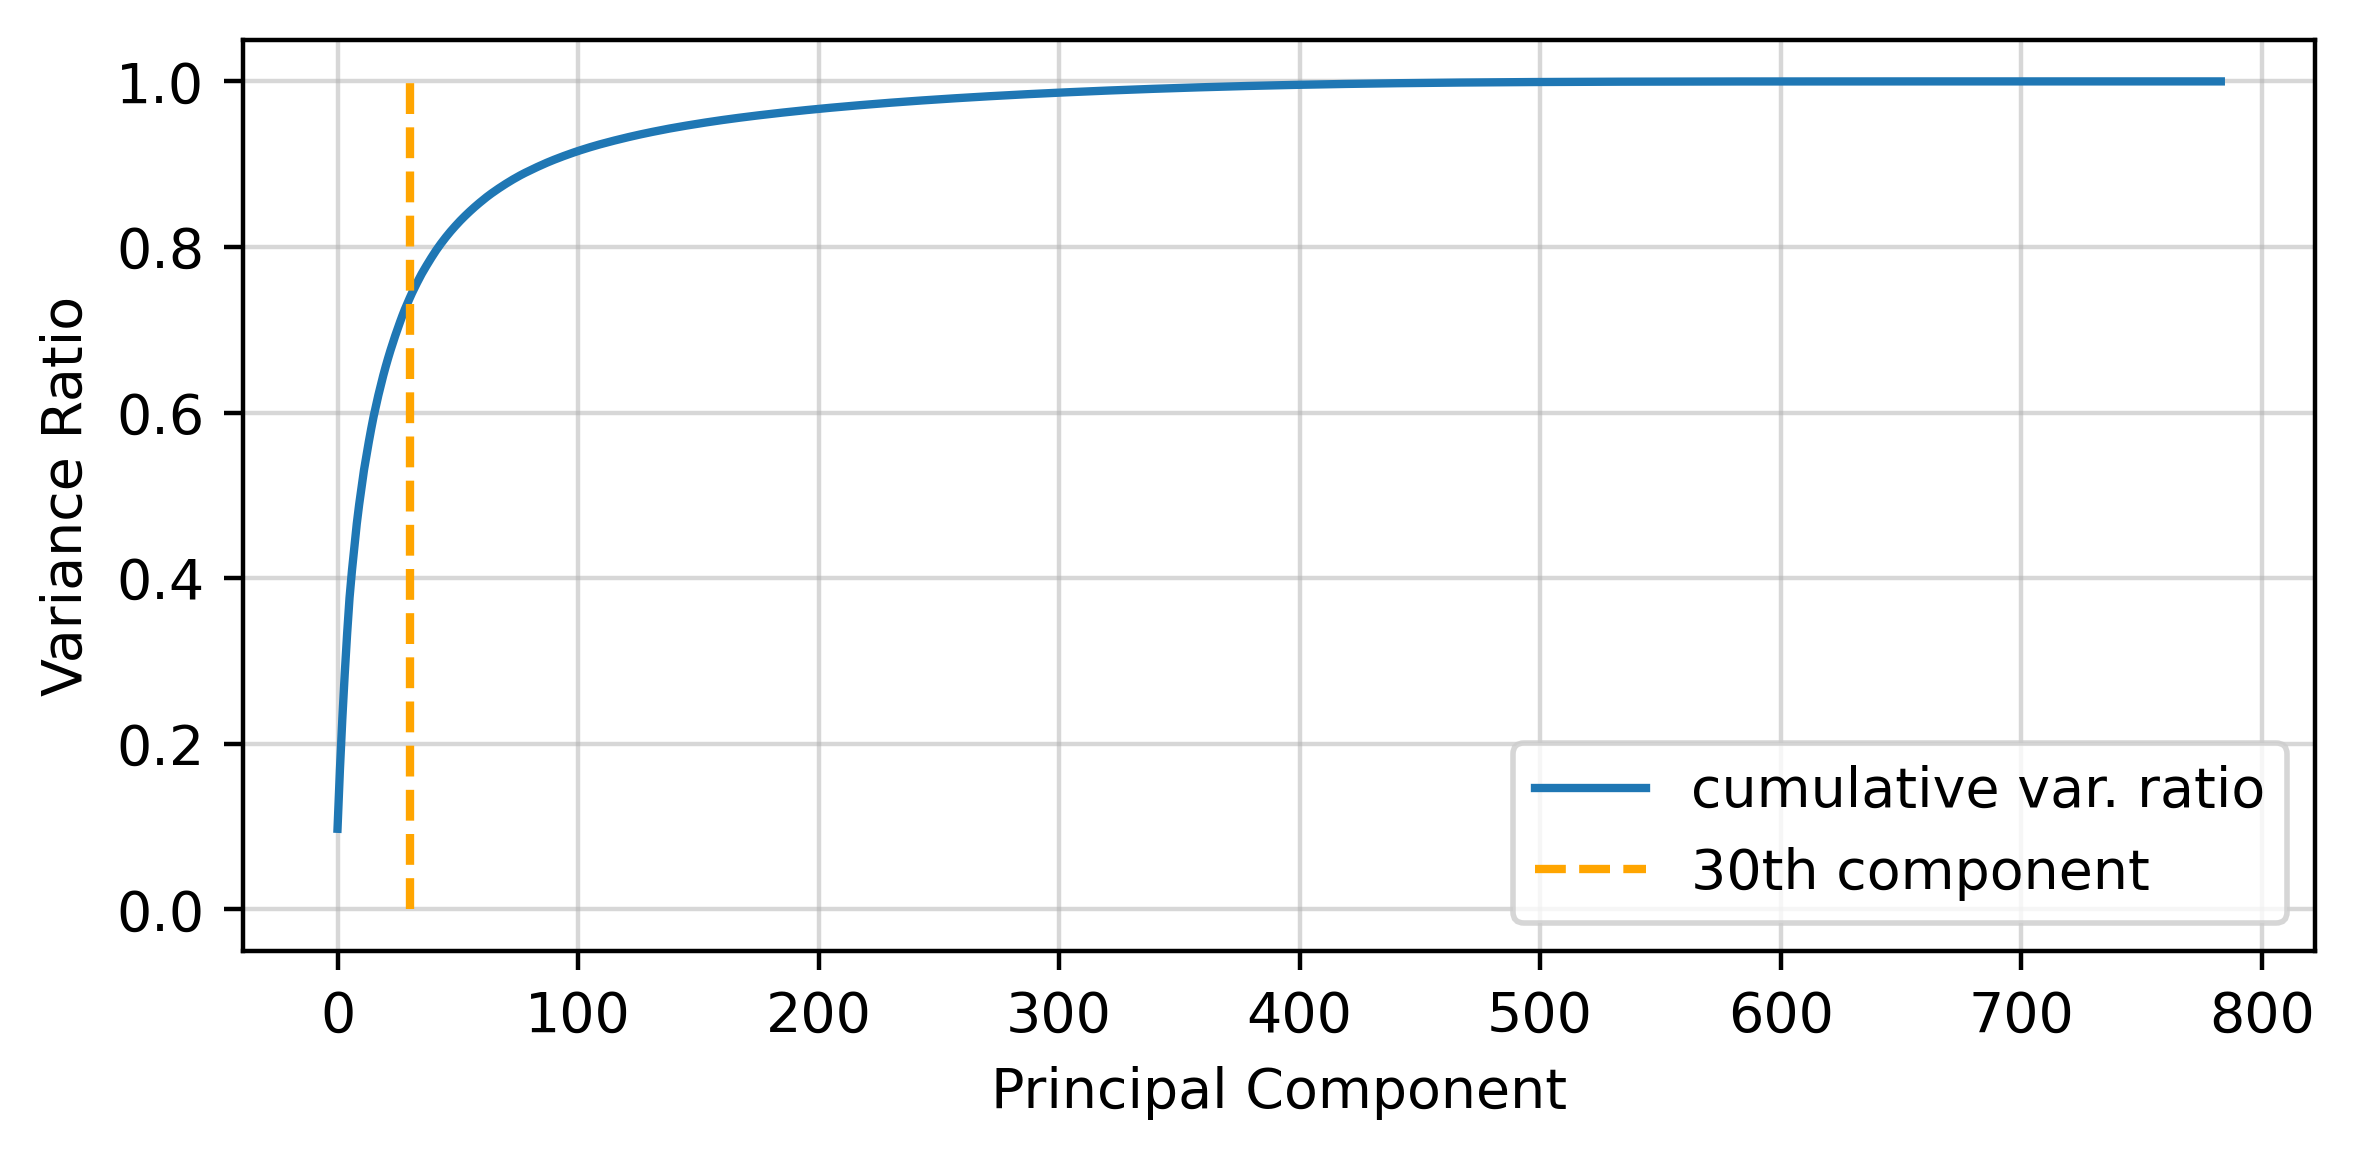

In [3]:
# Plot the magnitude of the eigenvalues
plt.figure(figsize=(6, 3), dpi=400)
plt.plot([_ for _ in range(X_mnist.shape[1])], np.cumsum(pca_mnist.explained_variance_ratio_), label='cumulative var. ratio')
plt.vlines(x = 30, ymin = 0, ymax = 1, color='orange', linestyles='dashed',
           label = '30th component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.legend()
plt.grid(visible=True, alpha=0.5)
plt.tight_layout()

# plt.savefig('out/figures/mnist_explained_variance.png')
plt.show()

In [3]:
# Find the number PCAs that explained 
components_mnist = [min(X_mnist.shape[0], X_mnist.shape[1]), 30]
var_fracs = [0.9, 0.75, 0.5, 0.25]
for var_frac in var_fracs:
    idx = np.where(np.cumsum(pca_mnist.explained_variance_ratio_) >= var_frac)[0][0]
    print(f'Percent information contained in the first {idx+1} components: ', np.cumsum(pca_mnist.explained_variance_ratio_)[idx])
    components_mnist.append(idx)


Percent information contained in the first 87 components:  0.90052297385683
Percent information contained in the first 33 components:  0.7506566429133847
Percent information contained in the first 11 components:  0.5102373275908383
Percent information contained in the first 4 components:  0.28454476018644703


In [4]:
# Get a subset of the data
# indices = np.random.choice(X_mnist.shape[0], 6000, replace=False)
# X_mnist_subset = X_mnist[:6_000]
# y_mnist_subset = y_mnist[:6_000]
classes = [i for i in range(10)]
X_mnist_subset, y_minst_subset = load_data('mnist', save_if_not_found=True, classes=classes, samples_per_class=600)
X_mnist_subset.shape

(6000, 784)

In [5]:
# Helper functions

def kl_divergence(p, q):
    return np.sum(np.where(q != 0, p * np.log(p / q), 0))

def neg_squared_euc_dists(X):
    """Compute matrix containing negative squared euclidean
    distance for all pairs of points in input matrix X

    # Arguments:
        X: matrix of size NxD
    # Returns:
        NxN matrix D, with entry D_ij = negative squared
        euclidean distance between rows X_i and X_j
    """
    # Math? See https://stackoverflow.com/questions/37009647
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D

def q_joint_tsne(Y):
    """t-SNE: Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    distances = neg_squared_euc_dists(Y)
    inv_distances = np.power(1. - distances, -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances)

In [6]:
def get_tsne_representations(X, components, p_joint_full):
    """Get the tsne representations for X, by first PCA-reducing :X: using the number of 
    components in :components:. Also compute the KL divergence between the solutions and :p_joint_full:"""

    tsne = TSNE(n_components=2, perplexity=40)

    representations = {}
    for n_components in components:
        pca = PCA(n_components=n_components)
        X_reduced = pca.fit_transform(X)
        y_tsne = tsne.fit_transform(X_reduced)
        representations[n_components] = {'x2d': y_tsne.copy(),
                                        'kld_pq': tsne.kl_divergence_}
        
        q_joint_reduced = q_joint_tsne(y_tsne)
    
        representations[n_components]['kld_pfull_qreduced'] = kl_divergence(p_joint_full.reshape(-1), 
                                                                        q_joint_reduced.reshape(-1))
        print(f'Representation from {n_components} components done.')

    return representations


In [7]:
# Get the p_joint from the original (unreduced) MNIST data
with open('data/p_joint/mnist_6k.pkl', 'rb') as f:
    p_data = pickle.load(f)
p_joint_full = p_data['P']

representations_mnist = get_tsne_representations(X_mnist_subset, components_mnist, p_joint_full)

/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 784 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 30 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 86 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 32 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 10 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 3 components done.


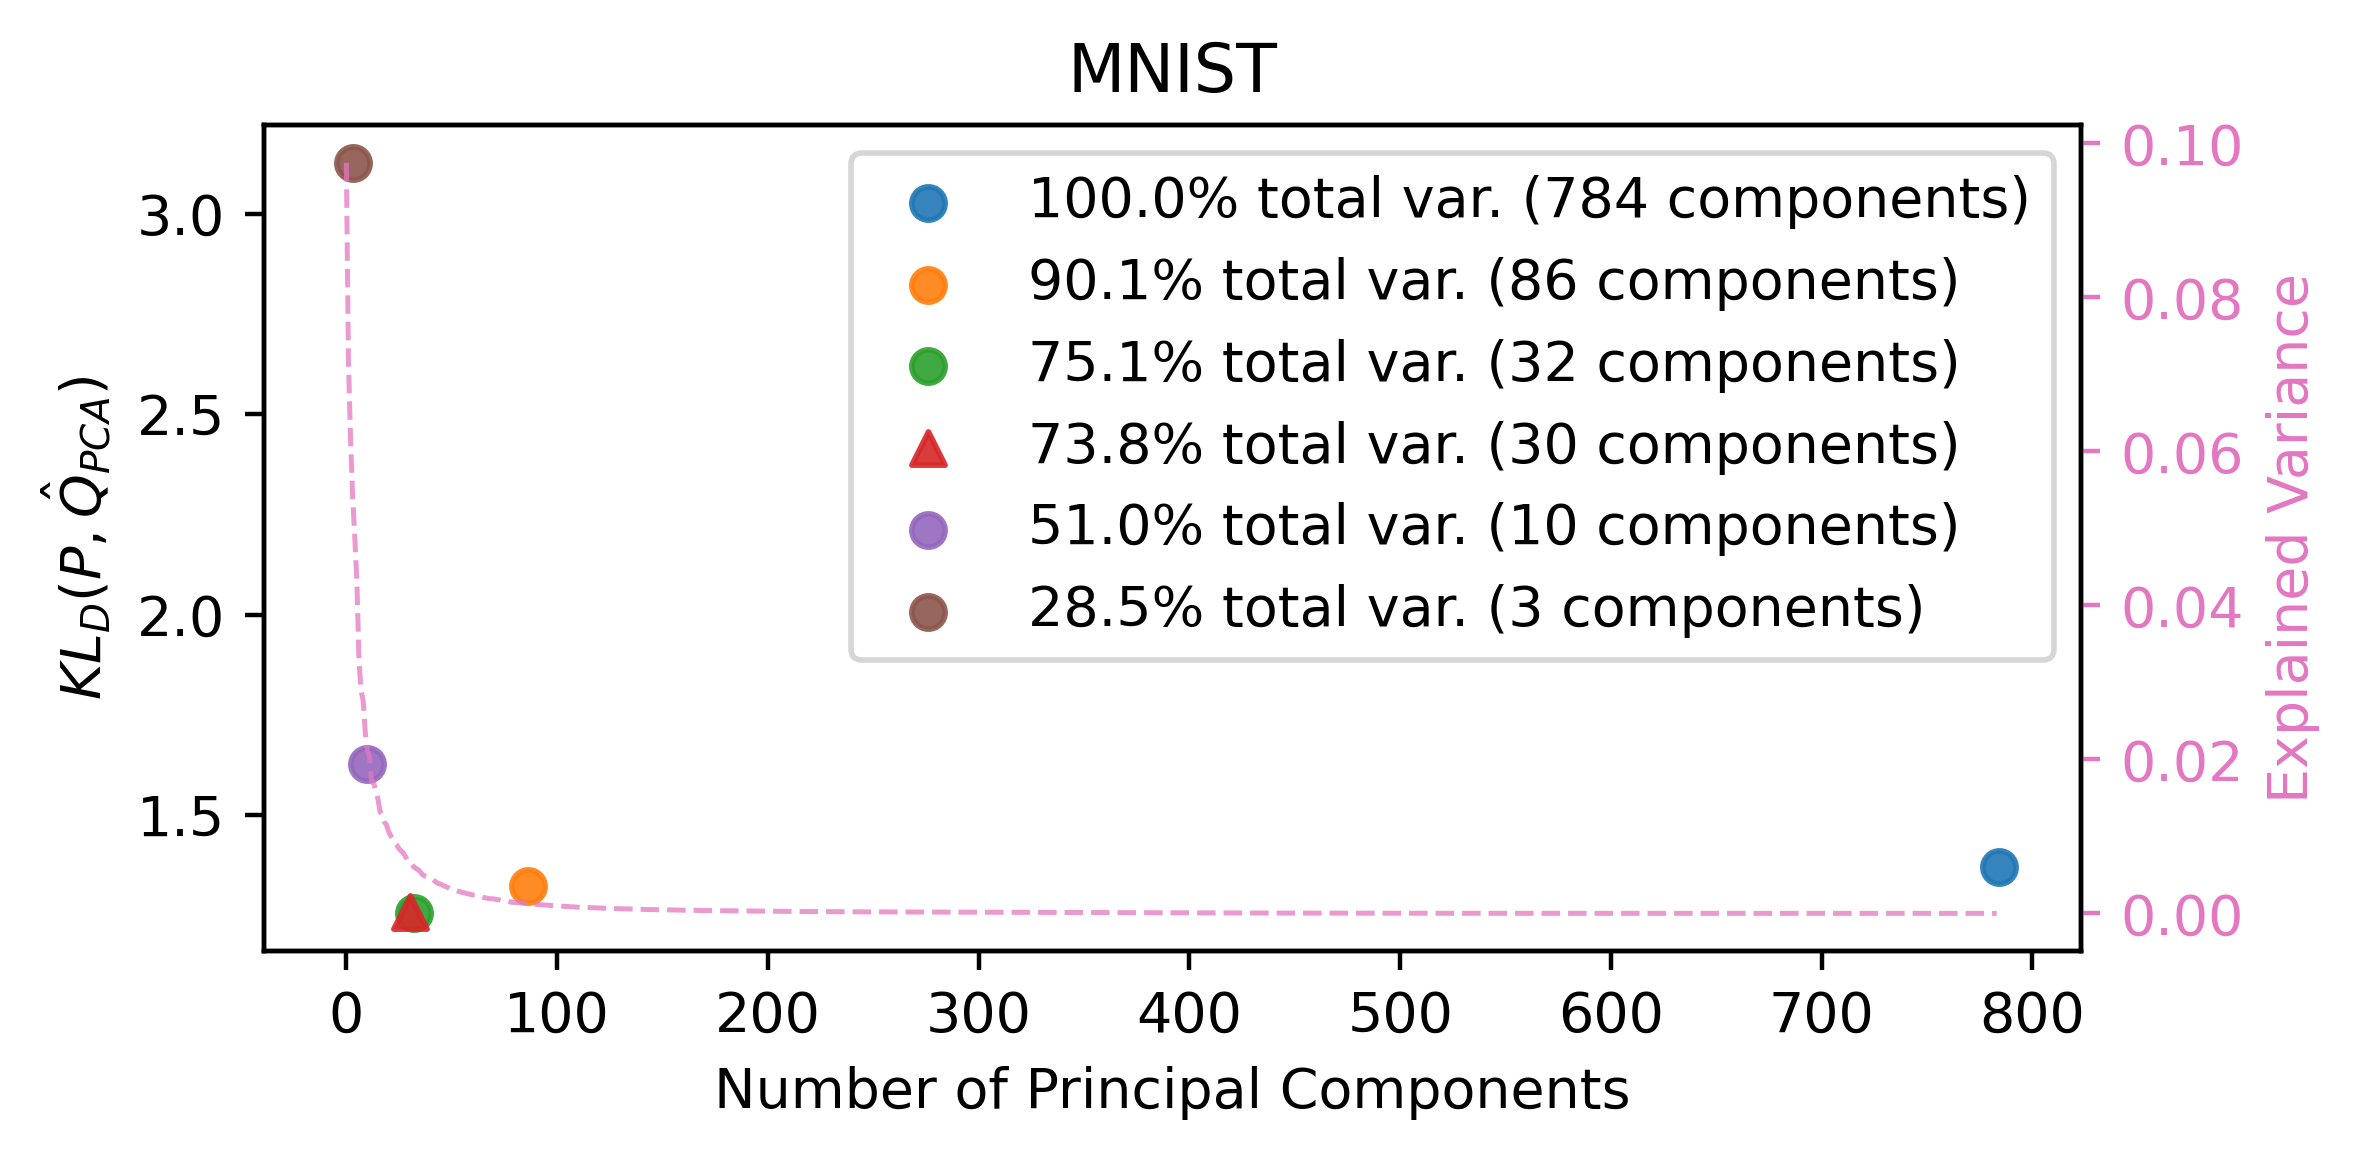

In [21]:
fix, ax1 = plt.subplots(figsize=(6,3), dpi=400)

for i, n_components in enumerate(sorted(representations_mnist.keys(), reverse=True)):

    if n_components == 784:
        total_var = 100
    else:
        total_var = np.cumsum(pca_mnist.explained_variance_ratio_)[n_components] * 100

    if n_components == 30:
        plt.scatter(n_components, representations_mnist[n_components]['kld_pfull_qreduced'], alpha=0.9, marker="^",
                    label=f'{total_var:.1f}% total var. ({n_components} components)')
    else:
        plt.scatter(n_components, representations_mnist[n_components]['kld_pfull_qreduced'], alpha=0.9,
                    label=f'{total_var:.1f}% total var. ({n_components} components)')

ax2 = ax1.twinx()
var, = ax2.plot([i for i in range(X_mnist.shape[1])], pca_mnist.explained_variance_ratio_, label='var. ratio', alpha=0.75,
         color='tab:pink', linestyle='dashed', linewidth=0.9)

ax1.legend()
ax2.yaxis.label.set_color(var.get_color())
ax2.tick_params(axis='y', colors=var.get_color())

ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel(r'$KL_{D}(P, \hat{Q}_{PCA})$')
ax2.set_ylabel('Explained Variance')
ax1.set_title('MNIST')
plt.tight_layout()
plt.savefig('out/figures/mnist_pca_kld.png', dpi=400)

In [51]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

def plot_representations(representations, y, title, legend=True, show=True, save=False):
    """
    Plot 2D visualization of the representations. Assumes there are six representations.
    """
    assert len(representations.keys()) == 6
    fig, ax = plt.subplots(2, 3, figsize=(12, 8)) 
    for i, n_components in enumerate(sorted(representations.keys())):
        j = 0 if i < 3 else 1

        x2d = representations[n_components]['x2d']
        ax[j][i % 3].scatter(x2d[:, 0], x2d[:, 1], c=y, cmap=plt.cm.gist_rainbow, s=10)

        ax[j][i % 3].set_title(f'{n_components} Principal Components')
        ax[j][i % 3].set_xticks([])
        ax[j][i % 3].set_yticks([])
    if legend:
        norm = Normalize(vmin=0, vmax=9)
        legend_handles = [Line2D([0], [0], marker='o', color='w', label=str(i),
                                markerfacecolor=plt.cm.gist_rainbow(norm(i)), markersize=5) for i in range(10)]
        ax[0][2].legend(handles=legend_handles,  bbox_to_anchor=(1.05, 1), loc='upper right')
            
    # plt.clim(-0.5, 9.5)
    # plt.axis('off')
    # plt.tight_layout()

    if save:
        plt.savefig(f"out/figures/{title}.png", dpi=400)
    if show:
        plt.show()

In [40]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

def plot_selected_representations(representations, y, title, components_to_plot, legend=True, show=True, save=False, y_label=None):
    """
    Plot 2D visualization five of the selected representations.
    """
    assert len(components_to_plot) == 5
    fig, ax = plt.subplots(1, 5, figsize=(15, 3)) 
    for i, n_components in enumerate(components_to_plot):

        x2d = representations[n_components]['x2d']
        ax[i].scatter(x2d[:, 0], x2d[:, 1], c=y, cmap=plt.cm.gist_rainbow, s=10)

        ax[i].set_title(f'{n_components} Principal Components')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    if legend:
        norm = Normalize(vmin=0, vmax=9)
        legend_handles = [Line2D([0], [0], marker='o', color='w', label=str(i),
                                markerfacecolor=plt.cm.gist_rainbow(norm(i)), markersize=5) for i in range(10)]
        ax[4].legend(handles=legend_handles,  bbox_to_anchor=(1.05, 1), loc='upper right')
            
    # plt.clim(-0.5, 9.5)
    # plt.axis('off')
    if y_label is not None:
        ax[0].set_ylabel(y_label, fontsize=18)

    plt.tight_layout()

    if save:
        plt.savefig(f"out/figures/{title}.png", dpi=400)
    if show:
        plt.show()

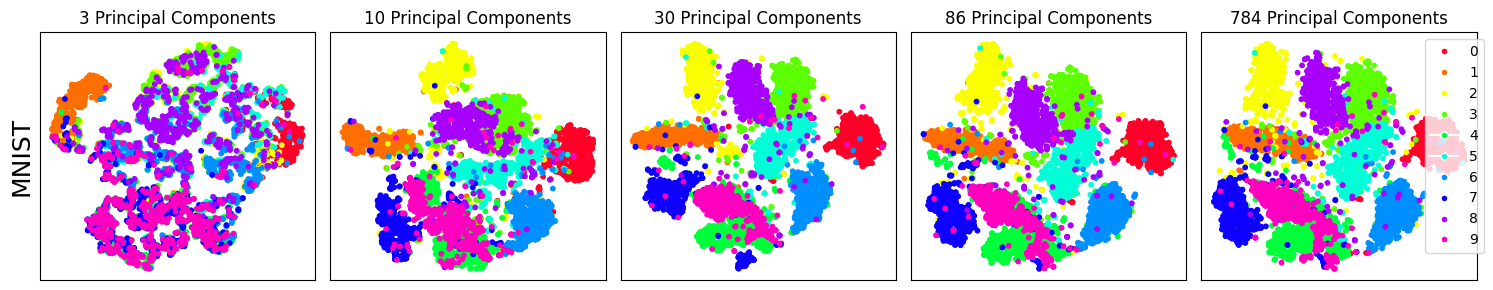

In [41]:
components_to_plot = [3, 10, 30, 86, 784]
plot_selected_representations(representations_mnist, y_minst_subset, 'mnist_pca_tsne_plots', 
                              components_to_plot, legend=True, show=True, save=True, y_label='MNIST')

# Olivetti Faces Dataset

## PCA Analysis

In [12]:
from data_loader import load_data

In [13]:
X_orl, y_orl = load_data('orl', save_if_not_found=True)
X_orl = X_orl.reshape(X_orl.shape[0], -1)
pca_orl = PCA()
pca_orl.fit(X_orl)

PCA()

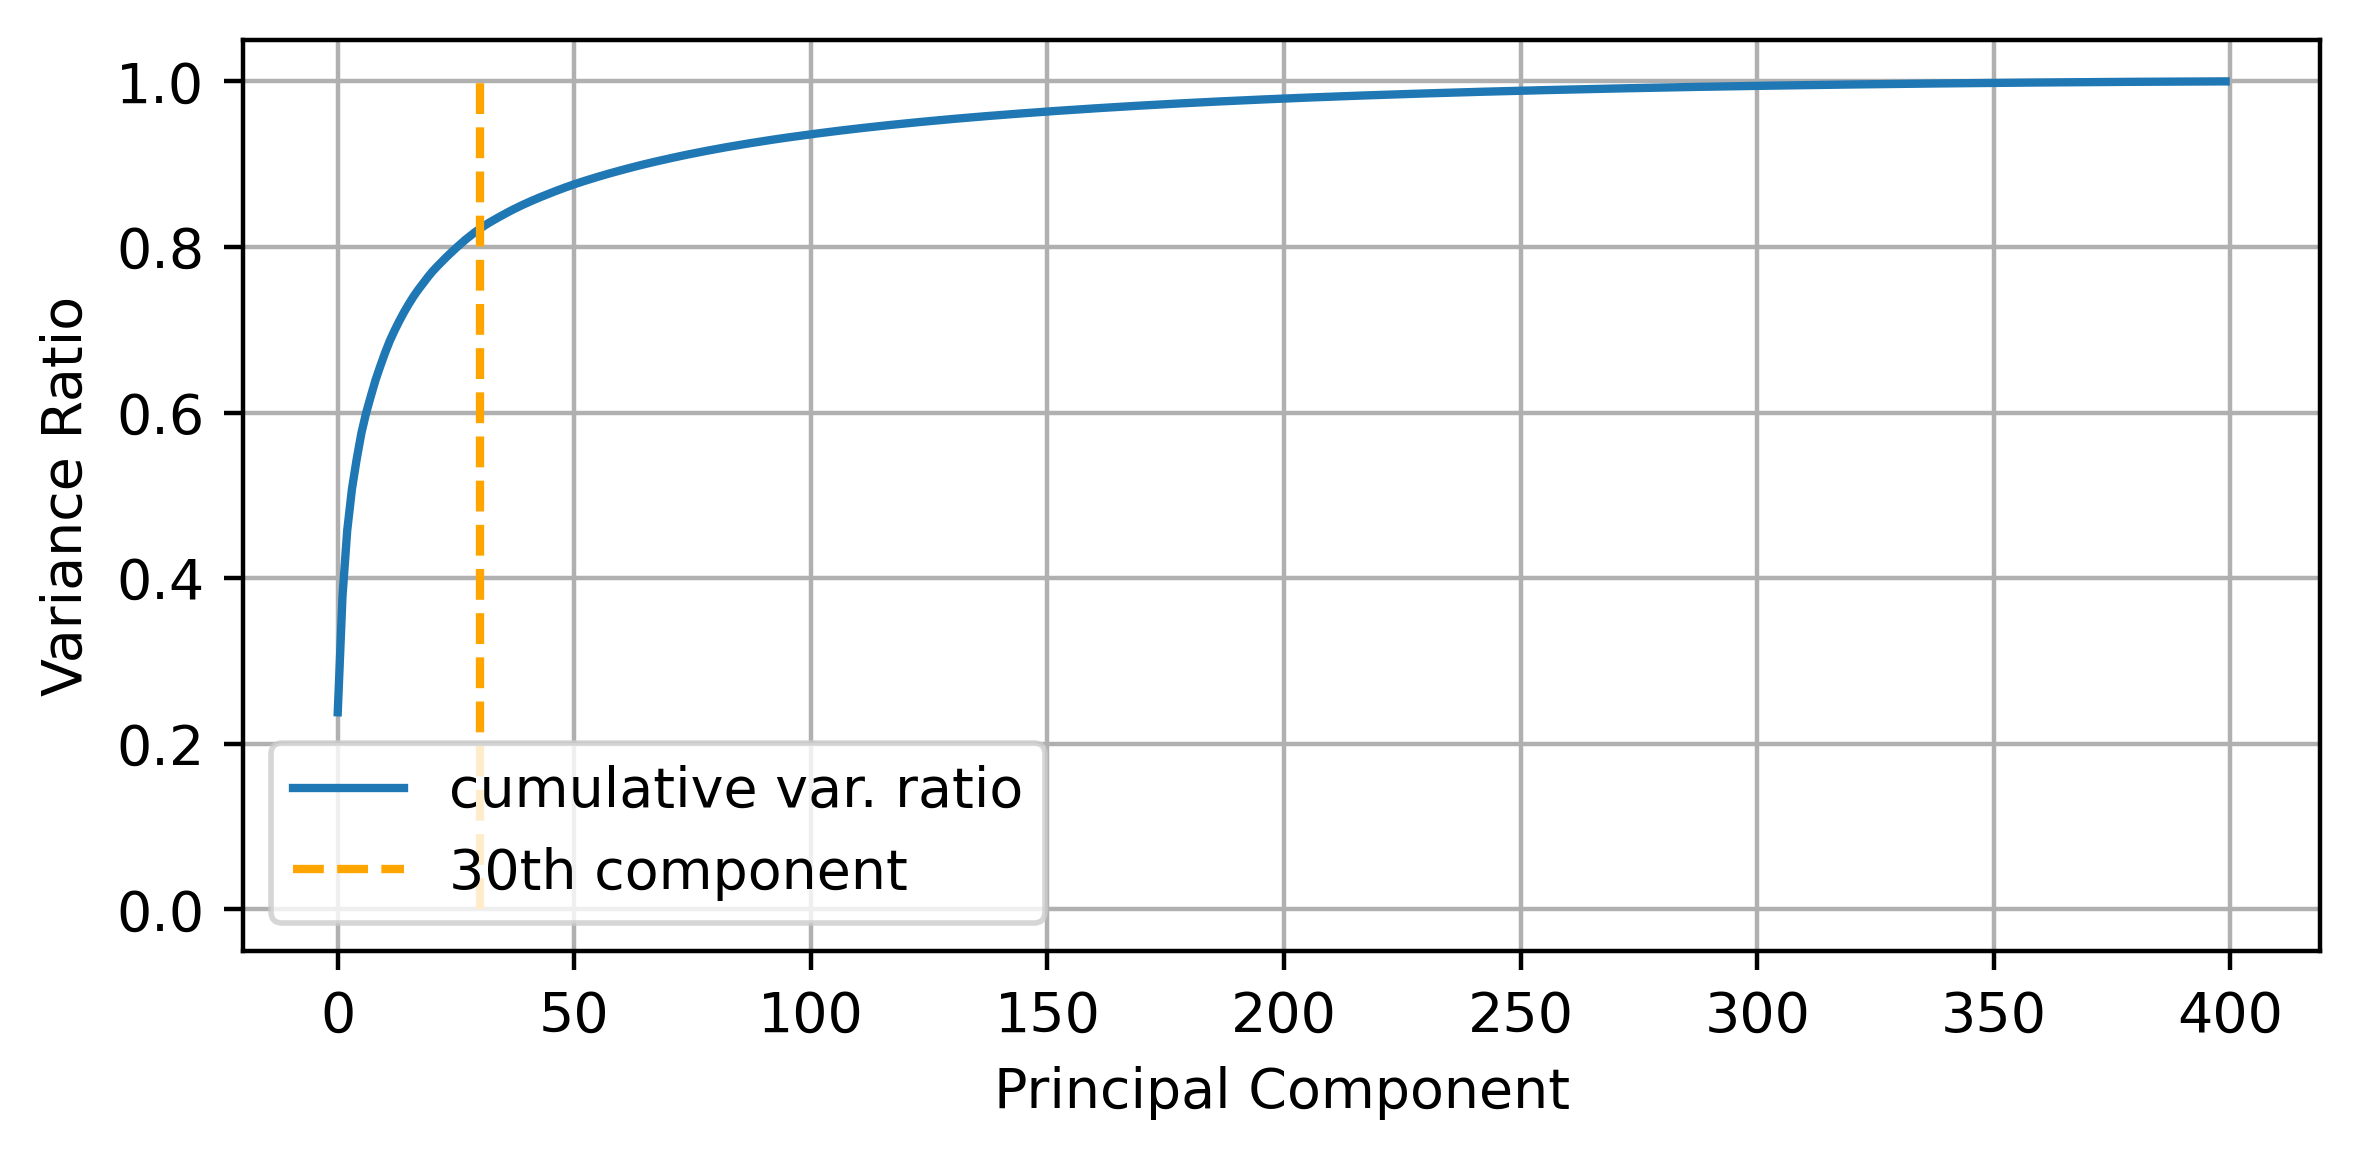

In [26]:
# Plot the magnitude of the eigenvalues
plt.figure(figsize=(6, 3), dpi=400)
plt.plot([_ for _ in range(pca_orl.n_components_)], np.cumsum(pca_orl.explained_variance_ratio_), label='cumulative var. ratio')
plt.vlines(x = 30, ymin = 0, ymax = 1, color='orange', linestyles='dashed',
           label = '30th component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.legend()
plt.grid(visible=True)
plt.tight_layout()

# plt.savefig('out/figures/orl_explained_variance.png')
plt.show()

In [14]:
# Find the number PCAs that explained 
components_orl = [min(X_orl.shape[0], X_orl.shape[1]), 30, 4]
var_fracs = [0.9, 0.75, 0.5]
for var_frac in var_fracs:
    idx = np.where(np.cumsum(pca_orl.explained_variance_ratio_) >= var_frac)[0][0]
    print(f'Percent information contained in the first {idx+1} components: ', np.cumsum(pca_orl.explained_variance_ratio_)[idx])
    components_orl.append(idx)

Percent information contained in the first 66 components:  0.90024525
Percent information contained in the first 19 components:  0.7558906
Percent information contained in the first 4 components:  0.50773627


In [15]:
# Get the p_joint from the original (unreduced) MNIST data
with open('data/p_joint/orl_P.pkl', 'rb') as f:
    p_data = pickle.load(f)
p_joint_full_orl = p_data['P']

representations_orl = get_tsne_representations(X_orl, components_orl, p_joint_full_orl)

/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 400 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 30 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 4 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 65 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 18 components done.
Representation from 3 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


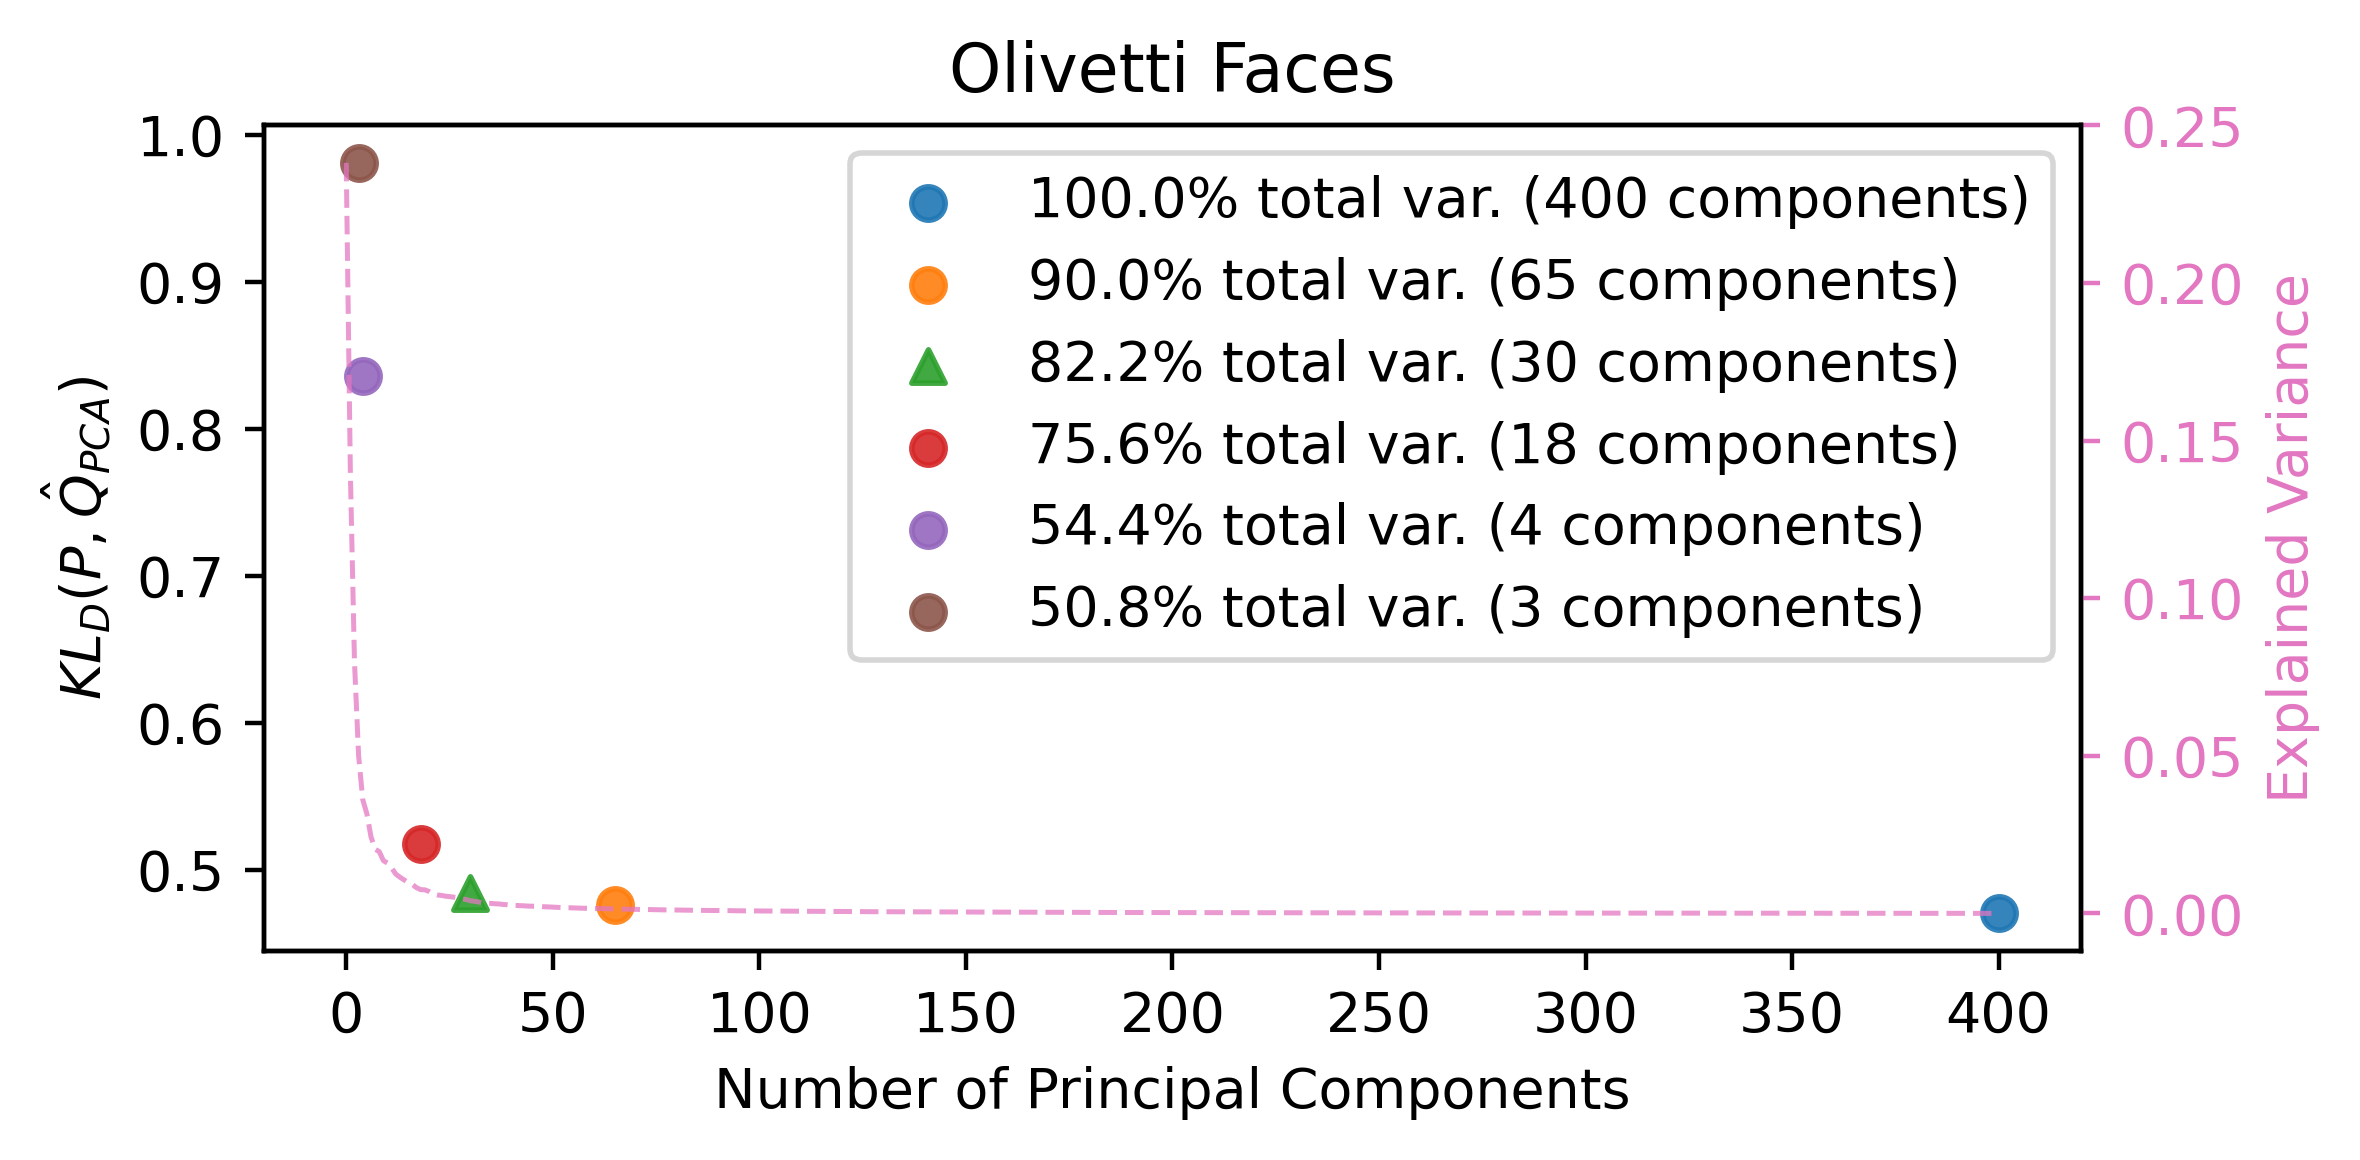

In [22]:
fix, ax1 = plt.subplots(figsize=(6,3), dpi=400)

for i, n_components in enumerate(sorted(representations_orl.keys(), reverse=True)):

    if n_components == 400:
        total_var = 100
    else:
        total_var = np.cumsum(pca_orl.explained_variance_ratio_)[n_components] * 100

    if n_components == 30:
        plt.scatter(n_components, representations_orl[n_components]['kld_pfull_qreduced'], alpha=0.9, marker="^",
                    label=f'{total_var:.1f}% total var. ({n_components} components)')
    else:
        plt.scatter(n_components, representations_orl[n_components]['kld_pfull_qreduced'], alpha=0.9,
                    label=f'{total_var:.1f}% total var. ({n_components} components)')

ax2 = ax1.twinx()
var, = ax2.plot([i for i in range(min(X_orl.shape))], pca_orl.explained_variance_ratio_, label='var. ratio', alpha=0.75,
         color='tab:pink', linestyle='dashed', linewidth=0.9)

ax1.legend()
ax2.yaxis.label.set_color(var.get_color())
ax2.tick_params(axis='y', colors=var.get_color())

ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel(r'$KL_{D}(P, \hat{Q}_{PCA})$')
ax1.set_title('Olivetti Faces')
ax2.set_ylabel('Explained Variance')
plt.tight_layout()
plt.savefig('out/figures/orl_pca_kld.png', dpi=400)


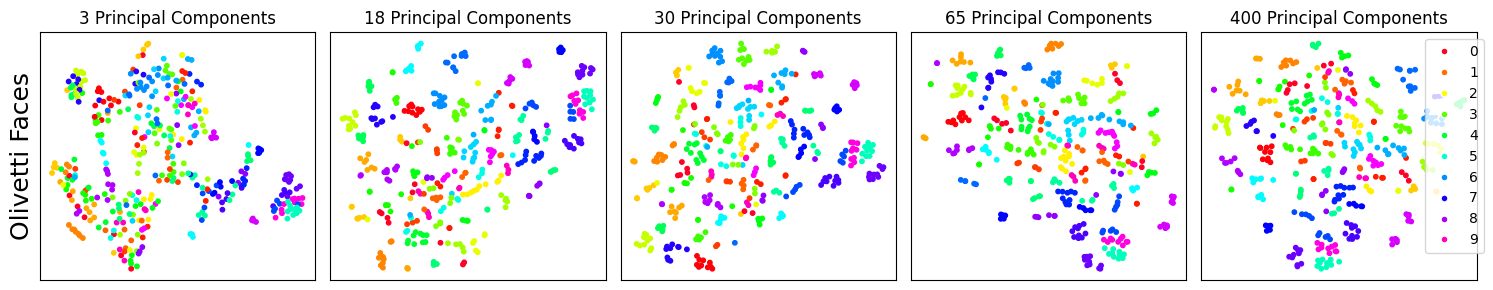

In [42]:
components_to_plot = [3, 18, 30, 65, 400]
plot_selected_representations(representations_orl, y_orl, 'orl_pca_tsne_plots', components_to_plot,
                     legend=True, show=True, save=True, y_label='Olivetti Faces')

# COIL-20 Dataset

In [18]:
X_coil, y_coil = load_data('coil20', save_if_not_found=True)
X_coil = X_coil.reshape(X_coil.shape[0], -1)
pca_coil = PCA()
pca_coil.fit(X_coil)

PCA()

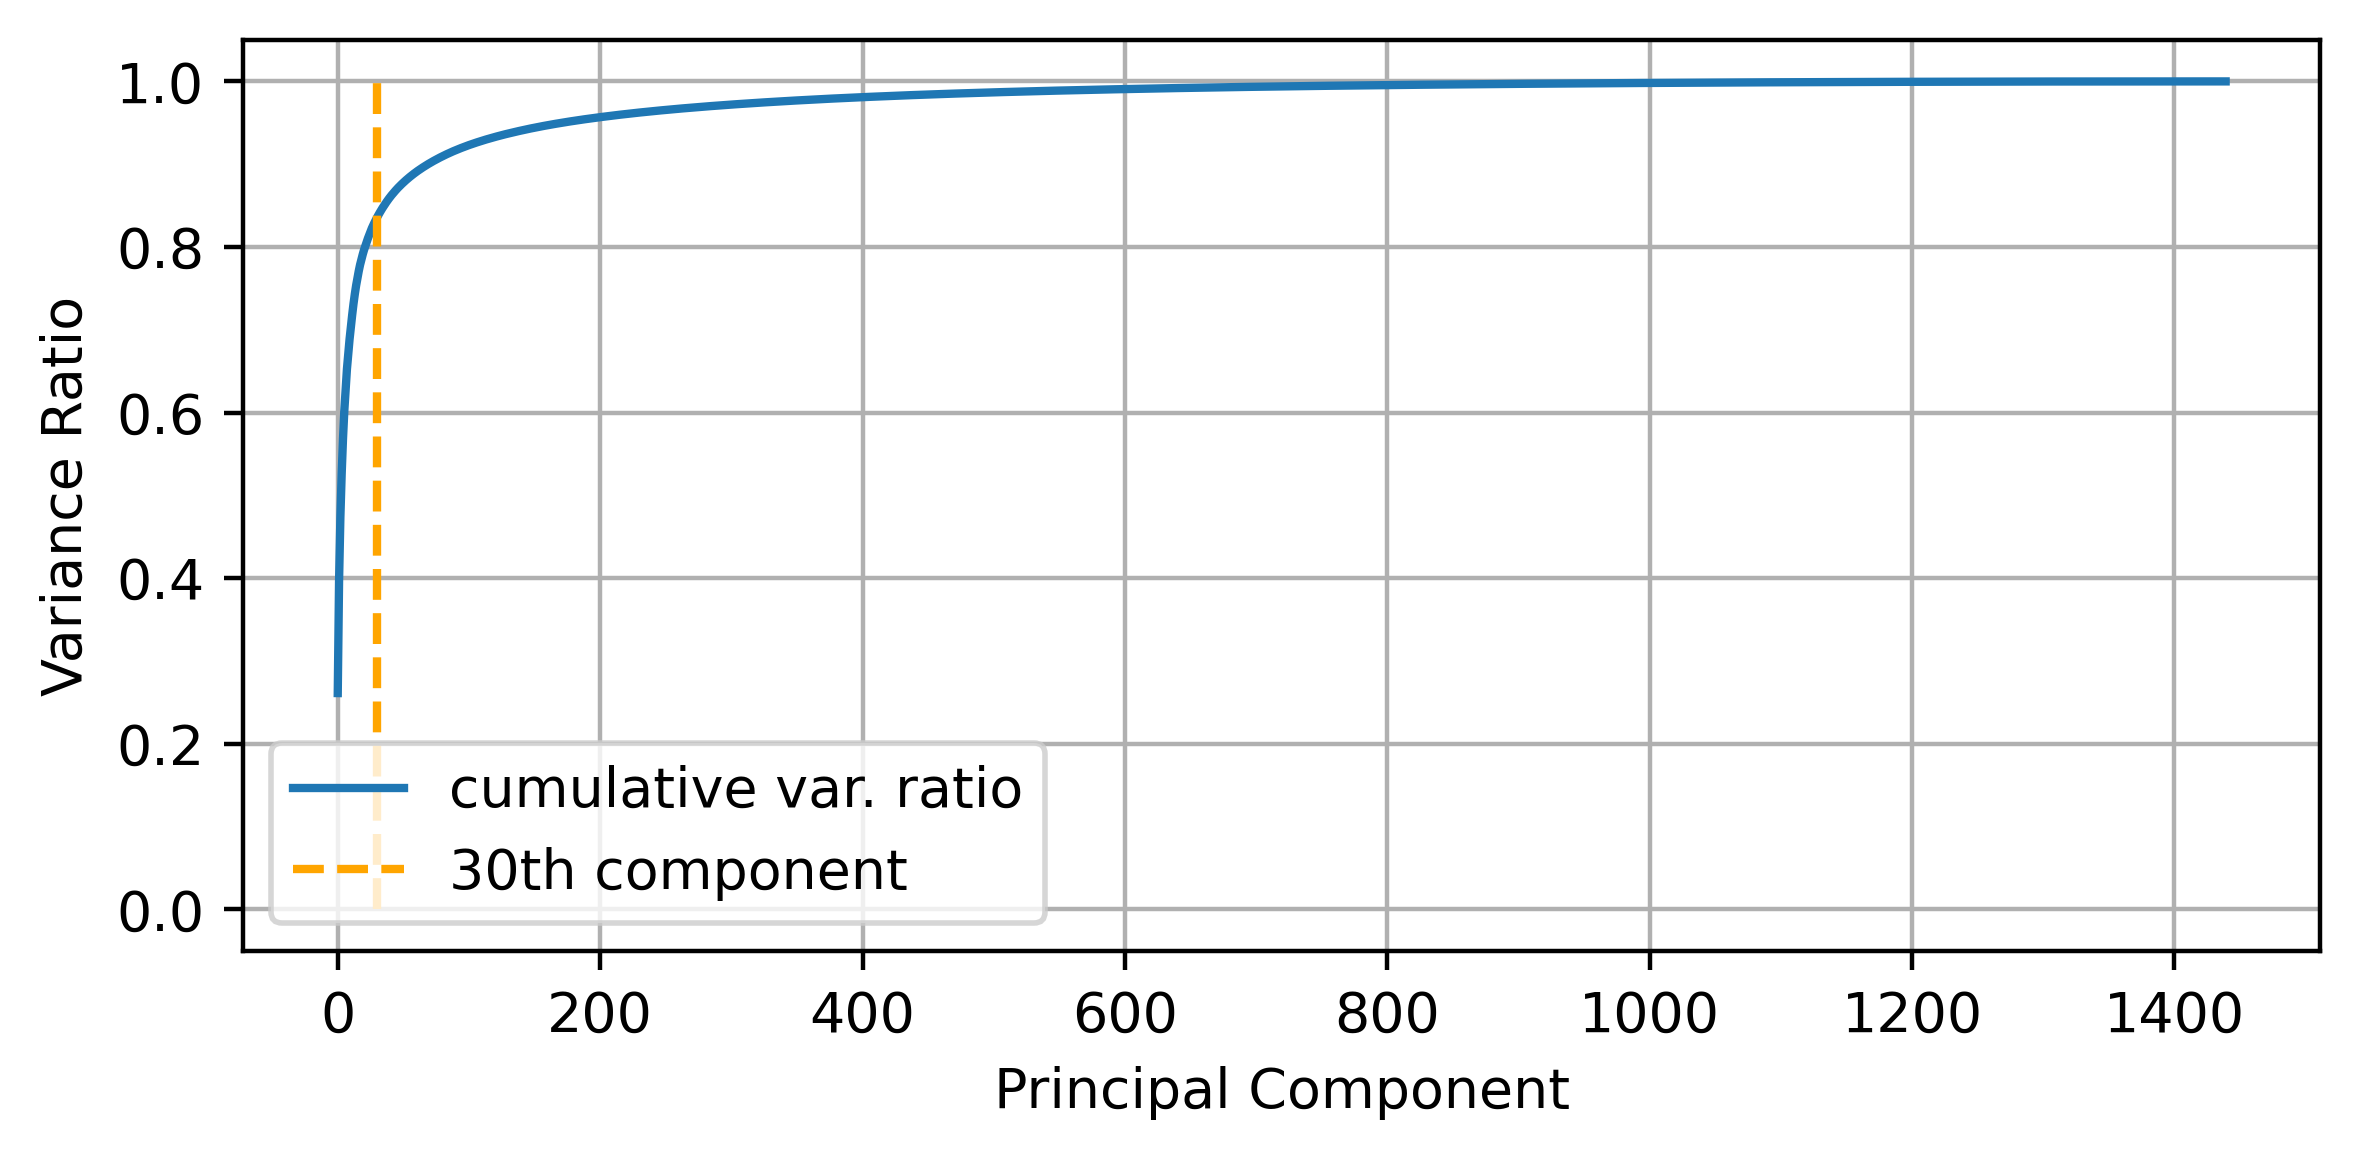

In [145]:
# Plot the magnitude of the eigenvalues
plt.figure(figsize=(6, 3), dpi=400)
plt.plot([_ for _ in range(pca_coil.n_components_)], np.cumsum(pca_coil.explained_variance_ratio_), label='cumulative var. ratio')
plt.vlines(x = 30, ymin = 0, ymax = 1, color='orange', linestyles='dashed',
           label = '30th component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.legend()
plt.grid(visible=True)
plt.tight_layout()

# plt.savefig('out/figures/coil_explained_variance.png', dpi=400)
plt.show()

In [19]:
# Find the number PCAs that explained percentages percent of the data
components_coil = [min(X_coil.shape), 30, 20]
var_fracs = [0.9, 0.75, 0.5]
for var_frac in var_fracs:
    idx = np.where(np.cumsum(pca_coil.explained_variance_ratio_) >= var_frac)[0][0]
    print(f'Percent information contained in the first {idx+1} components: ', np.cumsum(pca_coil.explained_variance_ratio_)[idx])
    components_coil.append(idx)

Percent information contained in the first 70 components:  0.9002416944265706
Percent information contained in the first 15 components:  0.7535255528732495
Percent information contained in the first 4 components:  0.5264963589550901


In [20]:
# Compute the KL divergence between the original attractions and the PCA-reduced data
with open('data/p_joint/coil_P.pkl', 'rb') as f:
    p_data = pickle.load(f)
p_joint_full_coil = p_data['P']

representations_coil = get_tsne_representations(X_coil, components_coil, p_joint_full_coil)

/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 1440 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 30 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 20 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 69 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


Representation from 14 components done.
Representation from 3 components done.


/tmp/ipykernel_57866/3711595346.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(q != 0, p * np.log(p / q), 0))


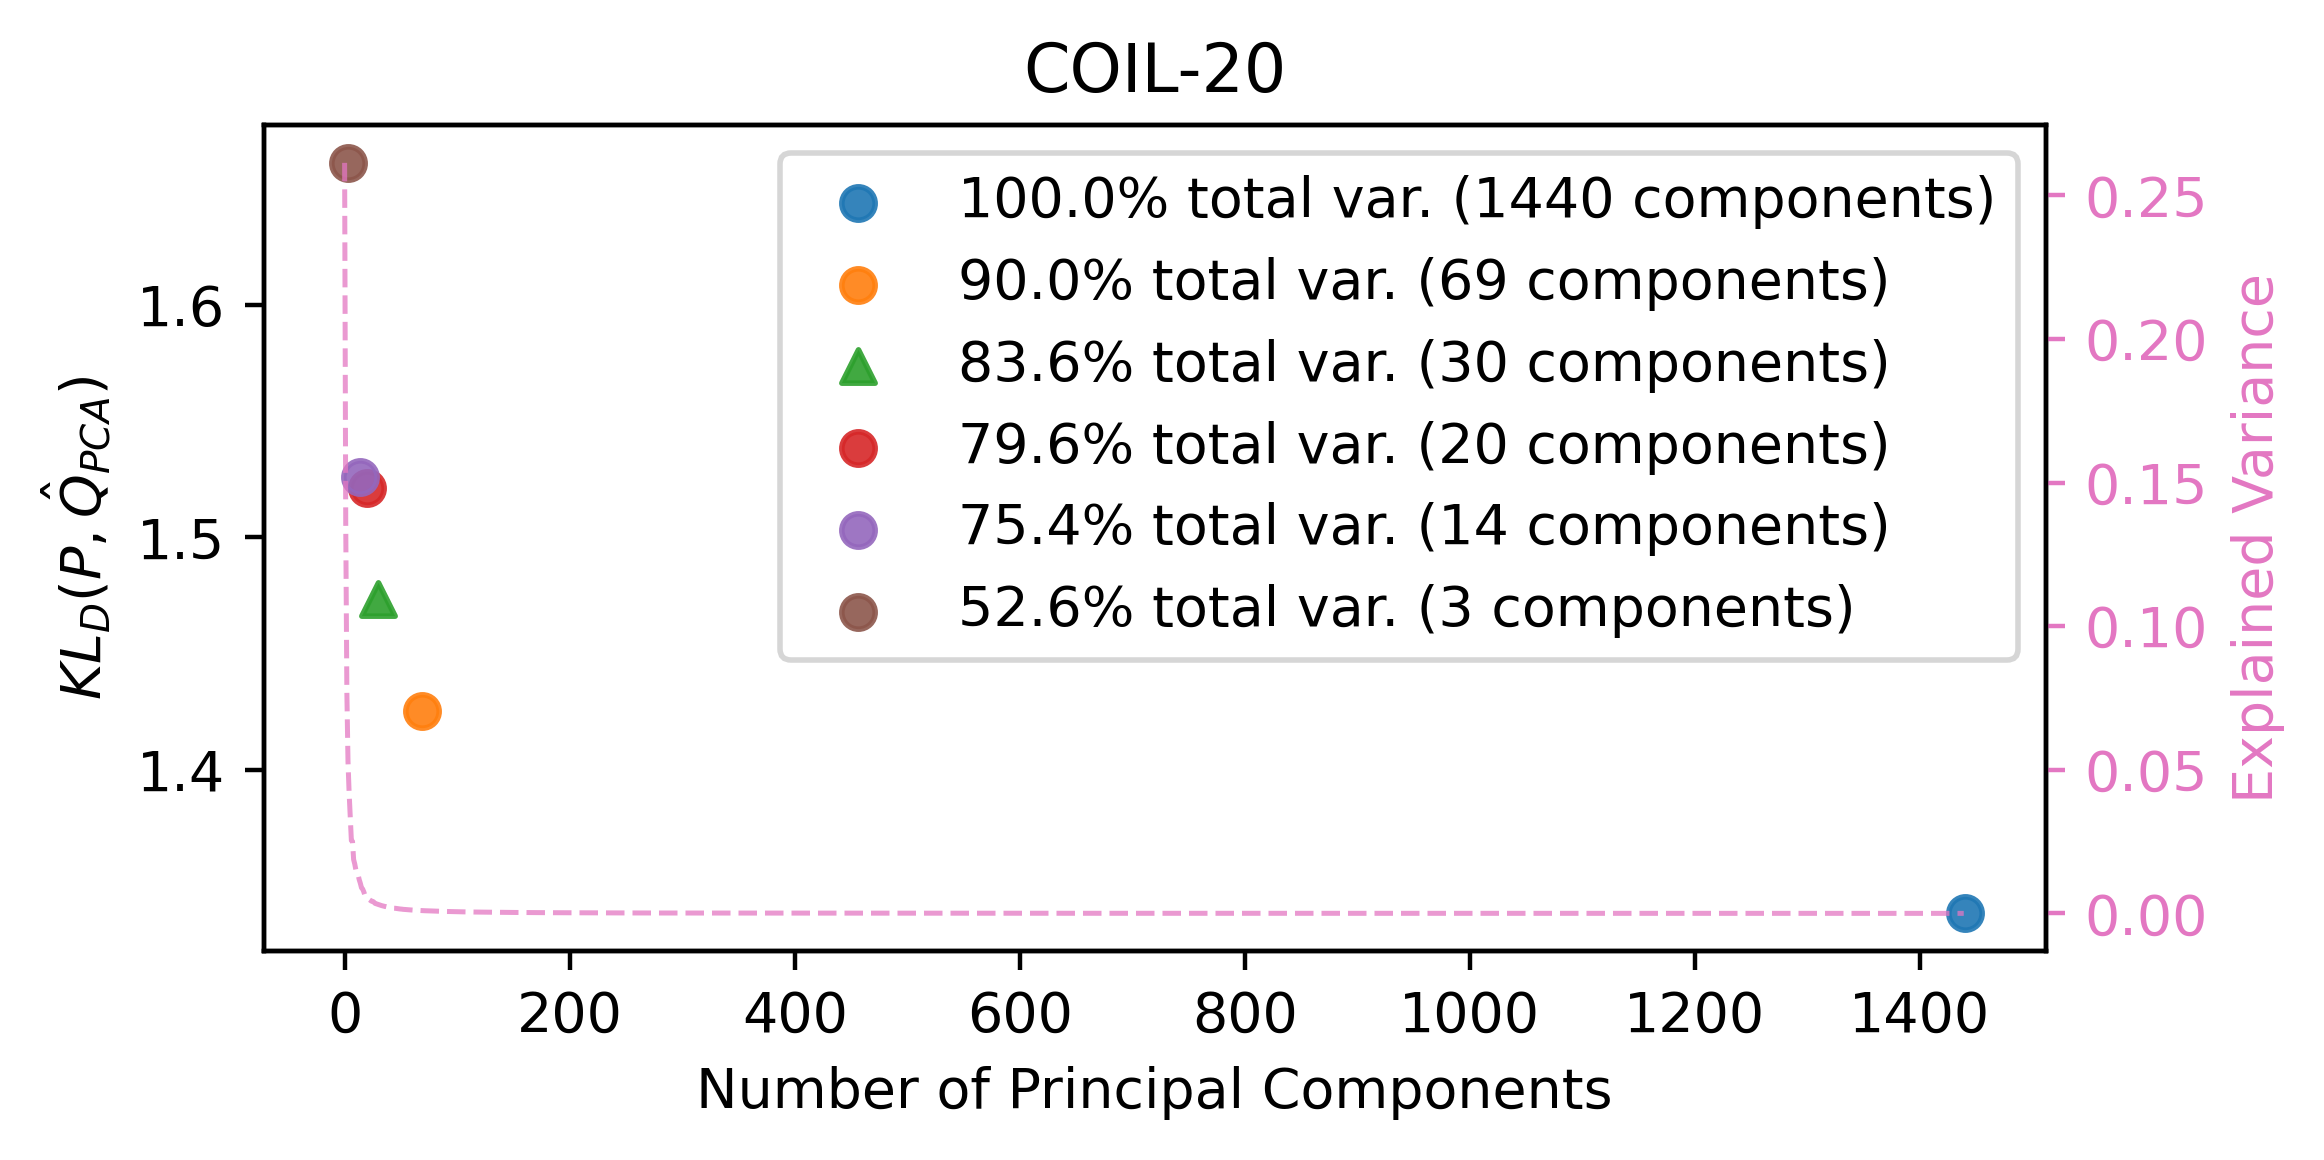

In [24]:
fix, ax1 = plt.subplots(figsize=(6,3), dpi=400)

for i, n_components in enumerate(sorted(representations_coil.keys(), reverse=True)):

    if n_components == 1440:
        total_var = 100
    else:
        total_var = np.cumsum(pca_coil.explained_variance_ratio_)[n_components] * 100

    if n_components == 30:
        plt.scatter(n_components, representations_coil[n_components]['kld_pfull_qreduced'], alpha=0.9, marker="^",
                    label=f'{total_var:.1f}% total var. ({n_components} components)')
    else:
        plt.scatter(n_components, representations_coil[n_components]['kld_pfull_qreduced'], alpha=0.9,
                    label=f'{total_var:.1f}% total var. ({n_components} components)')

ax2 = ax1.twinx()
var, = ax2.plot([i for i in range(min(X_coil.shape))], pca_coil.explained_variance_ratio_, label='var. ratio', alpha=0.75,
         color='tab:pink', linestyle='dashed', linewidth=0.9)

ax1.legend()
ax2.yaxis.label.set_color(var.get_color())
ax2.tick_params(axis='y', colors=var.get_color())

ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel(r'$KL_{D}(P, \hat{Q}_{PCA})$')
ax1.set_title('COIL-20')
ax2.set_ylabel('Explained Variance')
plt.tight_layout()
plt.savefig('out/figures/coil_pca_kld.png', dpi=400)

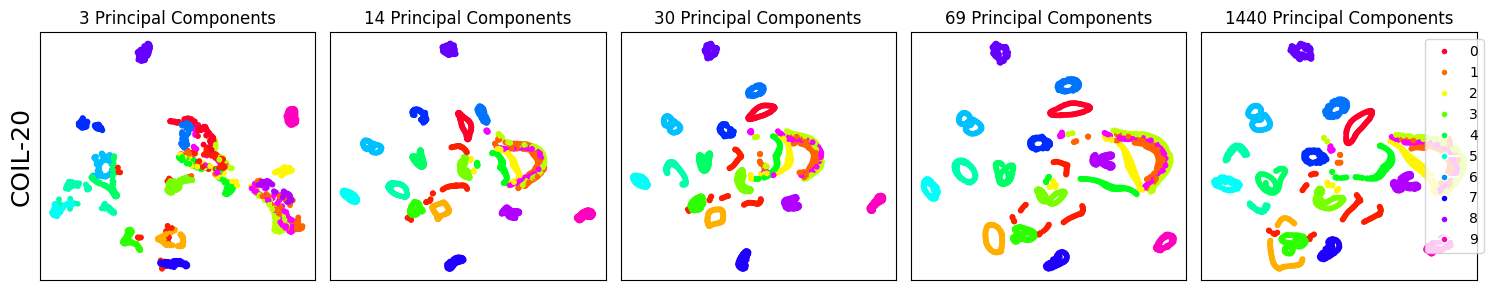

In [43]:
components_to_plot = [3, 14, 30, 69, 1440]
plot_selected_representations(representations_coil, y_coil, 'coil_pca_tsne_plots', components_to_plot,
                    legend=True, show=True, save=True, y_label='COIL-20')